In [1]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from market_data.market_data import get_daily_stats
%matplotlib inline

In [178]:
sim = pd.read_csv('c:/temp/SIM_RESULTS_12_8_ENRICHED.csv')
sim['date']=pd.to_datetime(sim['date'])
#Impute missing values with averages ( not great but not terrible )
for col in 'ar_vol ar_beta ADV'.split():
    sim[col].fillna((sim[col].mean()), inplace=True)

#temp remove me
sim2 = pd.read_csv('c:/temp/SIM_RESULTS_12_8.csv')
sim2['date']=pd.to_datetime(sim['date'])

if False:
    #Read results of the simulation. Add some columns
    sim = pd.read_csv('c:/temp/SIM_RESULTS_12_8.csv')
    sim['date']=pd.to_datetime(sim['date'])
    daily_stats = get_daily_stats(sim)
    sim=sim.merge(daily_stats,on=['sym','date'],how='left')
    sim['ew_return']=sim.c2cdn*np.sign(sim.predicted_c2cdn) ##c2c return assuming we go long whenever prediced_c2cdn is positive and short otherwise
    sim['ewo_return']=sim.o2cdn*np.sign(sim.predicted_c2cdn)  ##c2c return assuming we go long whenever prediced_c2cdn is positive and short otherwise
                                                              ## more realistic -assumes we open MOO positions based on prev close pricing
    sim['P'] = sim.model_order.apply(lambda x: eval(x)[0])
    sim['Q'] = sim.model_order.apply(lambda x: eval(x)[-1])
    sim['predicted_tstat'] = sim.predicted_c2cdn.abs()/sim.predicted_se ##Strength of our prediction - unsigned
    
print('SHAPE', sim.shape)
sim.head(2)


SHAPE (1055973, 23)


,Unnamed: 0.1,Unnamed: 0,date,sym,adjusted_close,o2c,c2c,benchmark,c2cb,o2cb,...,predicted_se,model_order,ar_vol,ar_beta,ADV,ew_return,ewo_return,P,Q,predicted_tstat
0,0,0,2007-07-02,ABBC,9.64,-0.011282,0.009424,SPY,0.009041,0.006098,...,0.011939,"(1, 0, 1)",0.018646,0.839000,49440.0,-0.000383,0.01738,1,1,0.141307
1,1,1,2007-07-03,ABBC,9.69,-0.008188,0.005187,SPY,0.003623,0.001051,...,0.011939,"(1, 0, 1)",0.018601,0.837517,49600.0,-0.001564,0.00924,1,1,0.243926


In [3]:
#Add quantiles for certain continuous varibales
q= list(np.arange(0,1.,.1))
for c in  "predicted_tstat ar_beta ar_vol".split():    
    ##quantiles = sim[c].quantile(q+[1]).values
    labels = [str(int(10*s)) for s in q]
    sim[f'{c}_q']= pd.qcut( sim[c],q+[1],retbins=False,labels=labels)

    ##print the resulting cuts
    #print(sim.groupby(f'{c}_q').agg( { c:[np.mean,np.min, np.max,len] } ))

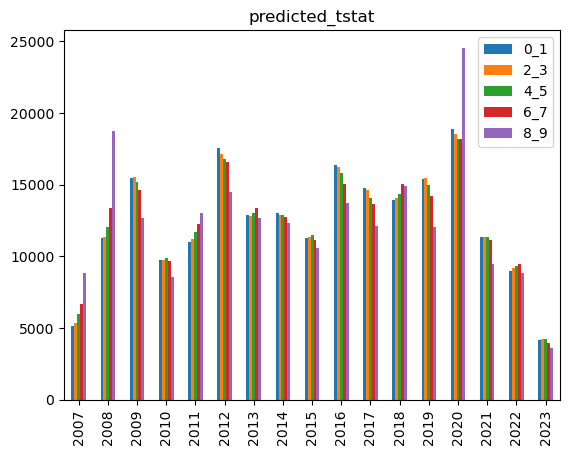

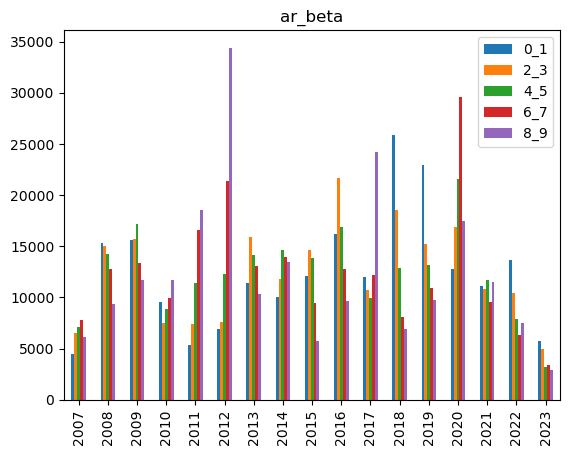

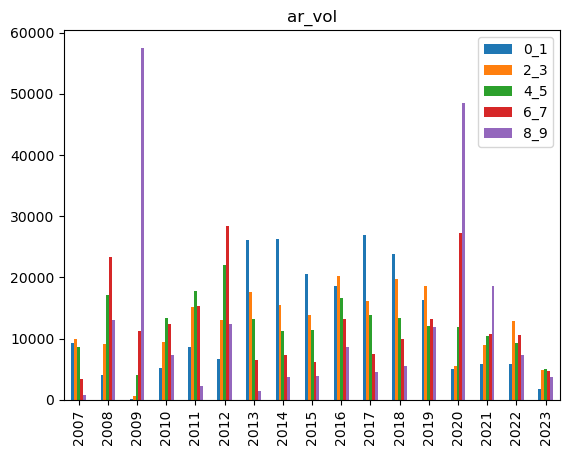

In [4]:
#Demographics by year
for col in  "predicted_tstat ar_beta ar_vol".split():    
    dates = sorted(sim.date.unique())
    df = pd.DataFrame(index=dates)
    groups = [[0,1],[2,3],[4,5],[6,7],[8,9]]
    for g in groups:
            df[ f'{g[0]}_{g[-1]}' ] = sim[ sim[col+'_q'].isin([str(x) for x in g])].groupby('date')['sym'].count()
    df.fillna(0,inplace=True)
    df = df.groupby(df.index.year).sum()
    df.plot.bar(stacked=False,title=col)
    plt.show()

In [5]:
for col in  "predicted_tstat ar_beta ar_vol".split():    
    stats=sim.groupby(sim[col+'_q']).agg({'ew_return':[np.mean,np.std,min,max],col: [np.min,np.max],
                                         'ewo_return': [np.mean]})
    with pd.option_context('display.float_format', '{:,.4f}'.format):
        print(f'{col} decile stats\n {stats}\n')


predicted_tstat decile stats
                   ew_return                       predicted_tstat           
                       mean    std     min    max             min     max   
predicted_tstat_q                                                           
0                    0.0001 0.0226 -0.4363 0.7715          0.0000  0.0277  \
1                    0.0001 0.0233 -0.7837 0.8651          0.0277  0.0560   
2                    0.0001 0.0227 -1.0665 0.6292          0.0560  0.0860   
3                    0.0001 0.0234 -0.6108 1.3055          0.0860  0.1183   
4                    0.0002 0.0238 -0.5859 1.1183          0.1183  0.1549   
5                    0.0003 0.0240 -0.6127 1.0791          0.1549  0.1979   
6                    0.0005 0.0246 -0.7000 0.6414          0.1979  0.2525   
7                    0.0006 0.0263 -0.9571 1.3646          0.2525  0.3302   
8                    0.0010 0.0275 -0.6049 1.1404          0.3302  0.4725   
9                    0.0019 0.0387 -0.8065 2.9

In [137]:
features = ['predicted_c2cdn','predicted_se','P','Q','predicted_tstat','ar_vol','ar_beta','ADV']
X = sim[features]
Y = sim['ew_return']
ct = make_column_transformer( (OneHotEncoder(),['model_order']),remainder="passthrough")
rf = RandomForestRegressor(n_estimators=100,max_depth=4,verbose=True)
#pipe = make_pipeline(ct,rf)
#pipe = make_pipeline(rf)
#pipe.fit(X,Y)
rf.fit(X,Y)
from sklearn.metrics import r2_score
print(f'R2 score {r2_score(Y, rf.predict(X))} ') 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  3.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


R2 score 0.0125560331609883 


<center> Feature Importance </center>

In [136]:
#fn = ct.get_feature_names_out()
fn = features
fi = rf.feature_importances_
fi_df = pd.DataFrame({'feature':fn,'importance':fi})
fi_df.sort_values('importance', ascending=False,inplace=True)
fi_df

,feature,importance
5,ar_vol,0.466292
0,predicted_c2cdn,0.271497
4,predicted_tstat,0.135159
6,ar_beta,0.065310
1,predicted_se,0.027548
7,ADV,0.020846
2,P,0.006867
8,dayofweek,0.003564
3,Q,0.002918


ALPHA(BPS) for predicted_tstat_q vs ar_vol_q


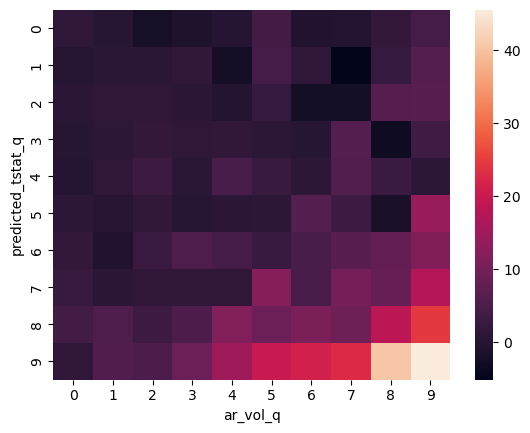

ar_vol_q              0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                  1.09  0.10 -1.98 -1.08 -0.10  3.85 -0.59 -0.39  1.79  4.00
1                  0.20  0.41  0.42  1.47 -2.25  4.11  1.03 -5.13  2.10  6.16
2                  0.66  1.28  1.14  0.80 -0.37  2.16 -2.39 -2.41  6.16  6.54
3                  0.07  0.87  1.77  1.16  1.56  0.86  0.06  6.11 -3.30  3.54
4                 -0.10  1.14  3.07  0.58  4.73  2.48  0.81  5.63  2.60  0.96
5                  0.84  0.32  1.46  0.08  0.65  0.87  6.07  3.05 -1.64 14.23
6                  1.61 -0.62  2.70  5.26  4.13  2.39  4.65  6.48  7.73 11.43
7                  2.55  0.63  1.21  1.06  1.30 12.07  4.66  9.96  8.30 17.50
8                  3.80  5.18  2.86  5.09 11.64  8.83 10.74  8.94 18.48 24.36
9                  1.21  5.50  5.08  8.88 14.90 19.88 21.27 22.72 40.42 45.48
COUNTS for predicted_tstat_q vs ar_vol_q
ar_vol_q               

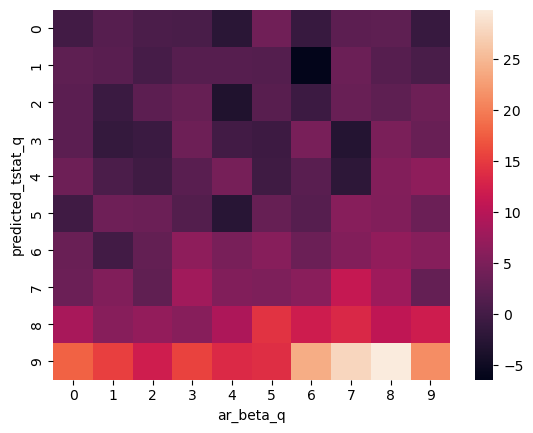

ar_beta_q             0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                 -0.11  1.69  0.65  0.52 -2.45  3.96 -1.18  2.34  2.45 -1.07
1                  2.45  1.98  0.29  1.70  1.73  1.51 -6.43  3.53  1.67  0.57
2                  2.10 -0.88  2.23  3.10 -3.44  1.85 -0.66  3.30  2.36  3.70
3                  2.14 -1.42 -0.79  3.66 -0.09 -0.62  4.64 -2.90  4.85  3.29
4                  3.62  0.73 -0.43  1.95  4.56 -0.44  2.02 -2.14  5.54  6.53
5                 -0.25  3.82  3.54  1.42 -2.53  3.19  1.77  5.92  5.44  3.58
6                  3.44 -0.08  2.87  6.59  4.65  5.95  3.49  5.58  6.86  5.86
7                  3.60  5.36  2.57  8.08  5.33  5.16  6.12 11.17  7.75  2.98
8                  8.61  6.02  6.92  5.99  9.08 14.30 11.95 13.35 10.57 11.92
9                 17.79 15.29 12.10 15.55 13.51 13.95 23.91 27.74 29.80 21.20
COUNTS for predicted_tstat_q vs ar_beta_q
ar_beta_q             

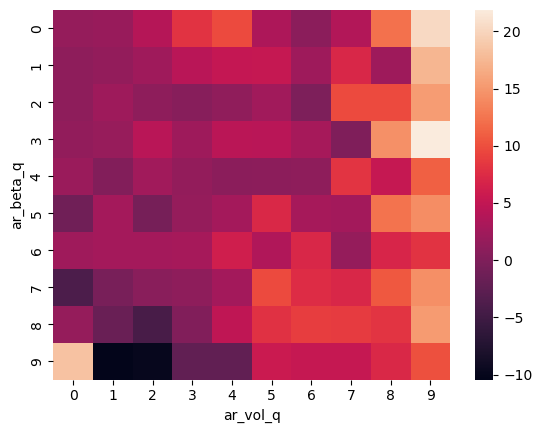

ar_vol_q      0      1     2     3     4    5     6     7     8     9
ar_beta_q                                                            
0          1.58   1.92  3.97  8.07  9.64 3.41  0.82  3.78 12.21 20.27
1          1.13   1.54  2.34  4.25  5.14 5.26  2.29  7.08  2.21 17.35
2          1.15   2.19  1.12  0.60  1.29 2.45 -0.16  9.68  9.71 15.33
3          1.32   1.79  4.31  2.20  4.37 4.25  2.91 -0.03 14.52 21.87
4          2.00   0.27  2.48  1.49  0.82 1.02  1.06  8.21  5.26 11.02
5         -1.16   2.72 -0.61  1.60  2.69 7.23  2.87  2.62 12.40 14.18
6          2.42   2.79  2.74  2.83  6.16 3.58  6.99  1.63  6.86  8.07
7         -3.96  -0.54  0.70  1.16  2.61 9.71  7.49  7.00 10.63 14.38
8          1.59  -1.64 -4.28  0.16  4.74 7.89  8.78  8.71  8.21 15.26
9         18.38 -10.44 -9.92 -2.27 -2.25 5.63  5.22  5.31  7.19 10.11
COUNTS for ar_beta_q vs ar_vol_q
ar_vol_q       0      1      2      3      4      5      6      7      8   
ar_beta_q                                          

In [8]:
#pairwise heat plot of features
counter=1
for f1,f2 in (['predicted_tstat_q','ar_vol_q'],['predicted_tstat_q','ar_beta_q'],['ar_beta_q','ar_vol_q']):
    hm = pd.pivot_table(sim, values='ew_return', index=f1, columns=f2, aggfunc='mean')
    hmcounts = pd.pivot_table(sim, values='ew_return', index=f1, columns=f2, aggfunc='count')
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        print(f'ALPHA(BPS) for {f1} vs {f2}' )
        ax = plt.subplot(1,1,1) 
        sns.heatmap(hm*10000,ax=ax)
        counter+=1
        plt.show()
        print(hm*10000)
    with pd.option_context('display.float_format', '{:.0f}'.format):
        print(f'COUNTS for {f1} vs {f2}' )
        print(hmcounts)


OVERALL ALPHA 4.59 bps, CNT 4028 STD 27.50 STD- 16.58bps STD+ 16.58bps sharpe 0.17 sortino 0.28
TS=4 ALPHA 3.10 bps, CNT 4028 STD 54.63 STD- 35.84bps STD+ 35.84bps sharpe 0.06 sortino 0.09
TS=6 ALPHA 4.11 bps, CNT 4028 STD 56.53 STD- 40.08bps STD+ 40.08bps sharpe 0.07 sortino 0.10
TS=7 ALPHA 5.58 bps, CNT 4028 STD 61.60 STD- 40.41bps STD+ 40.41bps sharpe 0.09 sortino 0.14
TS=9 ALPHA 13.06 bps, CNT 4028 STD 97.19 STD- 57.91bps STD+ 57.91bps sharpe 0.13 sortino 0.23
TS=0 ALPHA 1.40 bps, CNT 4028 STD 53.59 STD- 37.20bps STD+ 37.20bps sharpe 0.03 sortino 0.04
TS=1 ALPHA 0.84 bps, CNT 4028 STD 53.96 STD- 40.22bps STD+ 40.22bps sharpe 0.02 sortino 0.02
TS=8 ALPHA 8.63 bps, CNT 4028 STD 65.48 STD- 44.03bps STD+ 44.03bps sharpe 0.13 sortino 0.20
TS=5 ALPHA 2.61 bps, CNT 4028 STD 56.59 STD- 40.90bps STD+ 40.90bps sharpe 0.05 sortino 0.06
TS=3 ALPHA 1.62 bps, CNT 4028 STD 55.28 STD- 36.08bps STD+ 36.08bps sharpe 0.03 sortino 0.04
TS=2 ALPHA 0.54 bps, CNT 4028 STD 53.13 STD- 38.19bps STD+ 38.19bp

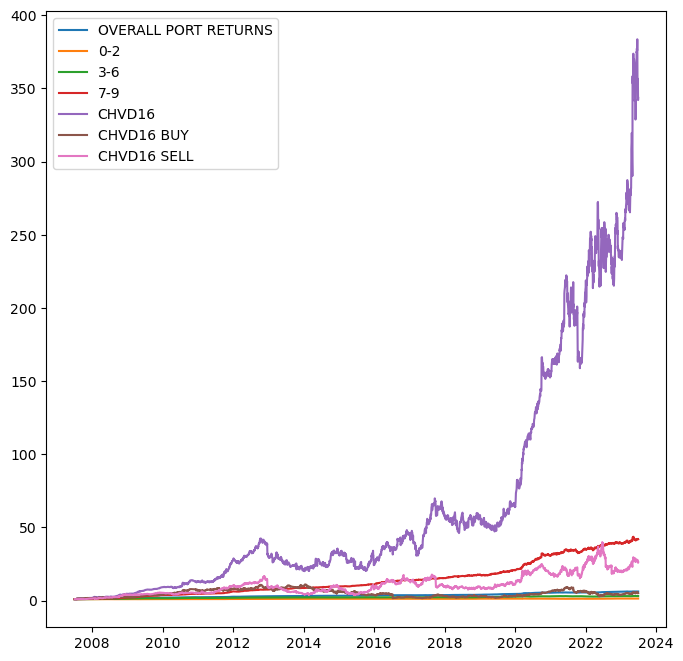

In [9]:
#Overall
def printstats(lbl,drets):
    alpha = drets.mean()
    std = drets.std()
    stdneg = drets[drets<0].std()
    stdpos = drets[drets>=0].std()
    sharpe = alpha/std
    sortino = alpha/stdneg
    
    print(f'{lbl} ALPHA {alpha*10000:.2f} bps, CNT {len(drets):.0f} STD { std*10000:.2f} STD- { stdneg*10000:.2f}bps STD+ { stdneg*10000:.2f}bps sharpe { sharpe:.2f} sortino { sortino:.2f}' )
drets = sim.groupby('date')['ew_return'].mean()
printstats('OVERALL', drets)
for ts in sim['predicted_tstat_q'].unique():
    drets = sim[sim.predicted_tstat_q==ts].groupby('date')['ew_return'].mean()
    printstats(f'TS={ts}',drets)


fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot(portRets,label='OVERALL PORT RETURNS')
grps = [[0,1,2],[3,4,5,6],[7,8,9]]
for grp in grps:
    pass
    pi = (1+sim[sim.predicted_tstat_q.isin([(str(g)) for g in grp])].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(pi,label= f'{min(grp)}-{max(grp)}')

#for th in [50,70,90]:
#    combo = (1+sim[(sim.TS.astype(float)>=th) & (sim.arvol_quantile.astype(float)>=th)].groupby('date')['ew_return'].mean()).cumprod()
#    plt.plot(combo,label= f'CHV{th}')

for th in [16]: #[80,100,120,160]:
    combo = (1+sim[(sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(combo,label= f'CHVD{th}')
#Conviction Hi Vol Diagonal 160 decomposed into buys and sells
th=16
chvdb = (1+sim[((sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th) & (sim.predicted_c2cdn>0)].groupby('date')['ew_return'].mean()).cumprod()
plt.plot(chvdb,label= f'CHVD{th} BUY')
chvds = (1+sim[((sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th) & (sim.predicted_c2cdn<0)].groupby('date')['ew_return'].mean()).cumprod()
plt.plot(chvds,label= f'CHVD{th} SELL')


plt.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot(portRets,label='OVERALL PORT RETURNS')
grps = [[0,10,20],[30,40,50,60],[70,80,90]]
for grp in grps:
    pi = (1+sim[sim.arvol_quantile.isin([(str(g)) for g in grp])].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(pi,label= f'{min(grp)}-{max(grp)}')
plt.legend()
plt.title('BY VOL QUANTILES')
plt.show()

In [15]:
def sharpes(s):
    sh = s.mean()/s.std()
    so = s.mean()/s[s<0].std()
    return sh,so
    
#hiconv trades
grps = [[],[0,1,2],[3,4,5,6,7,8,9],[3,4,5,6],[7,8,9],[9]]
for grp in grps:
    hc = sim[sim.ar_vol_q.isin([(str(g)) for g in grp])] if len(grp) else sim
    print(f'\nGroup {grp} len {len(hc)}')
          
    #hc = sim[sim.TS.isin(['70','80','90'])]
    #winners/losers by trade
    print(f'By trade winners - {len(hc[hc.ew_return>0])} losers {len(hc[hc.ew_return<0])} ')
    bysym = hc.groupby(hc.sym)['ew_return'].mean()
    print(f'By sym winners - {len(bysym[bysym>0])} losers {len(bysym[bysym<0])} ')
    
    bydate = hc.groupby(hc.date)['ew_return'].mean()
    bydatedf = bydate.reset_index()
    print(f'By date winners - {len(bydate[bydate>0])} losers {len(bydate[bydate<0])} sharpe/sort {sharpes(bydate)}')
    #bymonth = hc.groupby(hc.date.dt.to_period("M"))['ew_return'].mean()
    bymonth = bydatedf.reset_index().groupby(bydatedf.date.dt.to_period('M'))['ew_return'].apply(lambda g: (1+g).cumprod().to_list()[-1]-1)
    print(f'By bymonth winners - {len(bymonth[bymonth>0])} losers {len(bymonth[bymonth<0])} sharpe/sort {sharpes(bymonth)}')
    #byq = hc.groupby(hc.date.dt.to_period("Q"))['ew_return'].mean()
    byq = bydatedf.reset_index().groupby(bydatedf.date.dt.to_period('Q'))['ew_return'].apply(lambda g: (1+g).cumprod().to_list()[-1]-1)
    print(f'By byq winners - {len(byq[byq>0])} losers {len(byq[byq<0])} sharpe/sort {sharpes(byq)}')



Group [] len 1055973
By trade winners - 537688 losers 518236 
By sym winners - 2558 losers 2087 
By date winners - 2314 losers 1714 sharpe/sort (0.1667904688120211, 0.2767322257483775)
By bymonth winners - 150 losers 42 sharpe/sort (0.658051959987006, 1.8661121848462587)
By byq winners - 56 losers 8 sharpe/sort (0.8364913018870146, 4.983538602101074)

Group [0, 1, 2] len 316792
By trade winners - 160406 losers 156370 
By sym winners - 1148 losers 1075 
By date winners - 2032 losers 1719 sharpe/sort (0.048378456138144836, 0.05689557106707239)
By bymonth winners - 121 losers 61 sharpe/sort (0.2345618976335165, 0.2602880395874996)
By byq winners - 43 losers 18 sharpe/sort (0.44776671815858177, 0.9468694817846378)

Group [3, 4, 5, 6, 7, 8, 9] len 739181
By trade winners - 377282 losers 361866 
By sym winners - 2438 losers 1980 
By date winners - 2290 losers 1738 sharpe/sort (0.1590126848547821, 0.2692922213174918)
By bymonth winners - 145 losers 47 sharpe/sort (0.6694919514438707, 1.93846

     ew_return                      
          mean    std    len std_err
date                                
1       0.0005 0.0323  30579  0.0002
2       0.0005 0.0267  99625  0.0001
3       0.0003 0.0284  31966  0.0002
4       0.0001 0.0259  30450  0.0001
5       0.0005 0.0260  31880  0.0001
6       0.0004 0.0271  33081  0.0001
7       0.0004 0.0248  32701  0.0001
8       0.0002 0.0272  33812  0.0001
9       0.0004 0.0277  34044  0.0002
10      0.0009 0.0292  32919  0.0002
11      0.0004 0.0256  33348  0.0001
12      0.0005 0.0243  33205  0.0001
13      0.0008 0.0263  33874  0.0001
14      0.0007 0.0227  33468  0.0001
15      0.0005 0.0235  32709  0.0001
16      0.0004 0.0246  32667  0.0001
17      0.0002 0.0259  32834  0.0001
18      0.0002 0.0277  31683  0.0002
19      0.0007 0.0273  32012  0.0002
20      0.0004 0.0255  32370  0.0001
21      0.0008 0.0240  32266  0.0001
22      0.0006 0.0245  32838  0.0001
23      0.0004 0.0245  33754  0.0001
24      0.0004 0.0256  32591  0.0001
2

<AxesSubplot:xlabel='date'>

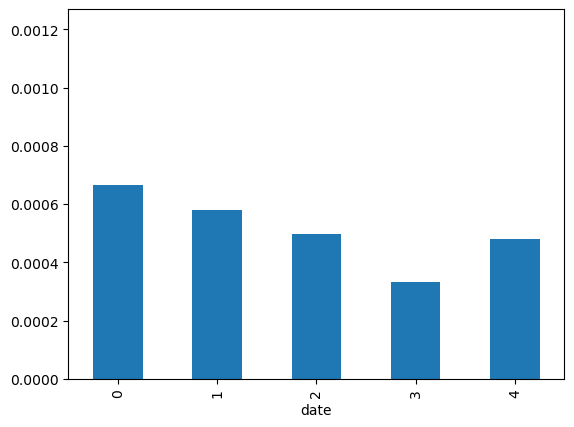

In [134]:
#Is there a day of month effect ( which could be because we recalbrate monthly )
bydayOfMonth = sim.groupby(sim['date'].dt.day).agg({'ew_return':[np.mean,np.std,len]})
bydayOfMonth[('ew_return','std_err')] = bydayOfMonth[('ew_return','std')]/np.sqrt(bydayOfMonth[('ew_return','len')])
bydayOfWeek = sim.groupby(sim['date'].dt.dayofweek).agg({'ew_return':[np.mean,np.std,len]})
bydayOfWeek[('ew_return','std_err')] = bydayOfWeek[('ew_return','std')]/np.sqrt(bydayOfWeek[('ew_return','len')])

with pd.option_context('display.float_format', '{:,.4f}'.format):
    print(bydayOfMonth)
    print(bydayOfWeek)

bydayOfMonth[('ew_return','mean')].plot.bar()
bydayOfWeek[('ew_return','mean')].plot.bar()


In [139]:
### Dynamic notional allocation scheme that takes into account predicted_tstat_q, ar_vol_q and beta to allocate dollars by trade
def getAllocationWeights(mults:np.ndarray):
    tstatMultipliers,volMultipliers = mults[0:10],mults[11:20]
    PREDICTED_TSTAT_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)],tstatMultipliers))
    AR_VOL_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)],         volMultipliers))
    t1 = sim['predicted_tstat_q'].map(PREDICTED_TSTAT_Q_MULTIPLIER).astype(float)
    t2 = sim['ar_vol_q'].map(AR_VOL_Q_MULTIPLIER).astype(float)
    score = t1*t2
    dailyScore = score.groupby(sim.date).sum()
    dailyScore.name='dailyScore'
    allocationWeight=score/sim.merge(dailyScore, on='date')['dailyScore']
    return allocationWeight
    
GLOBAL_COUNTER=0
def getSortino(mults:np.ndarray,verbose=False)->int:
    #print(f'Invoked with {mults}')
    global GLOBAL_COUNTER
    allocationWeight = getAllocationWeights(mults)
    dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
    sortino =  dynamicReturns.mean()/dynamicReturns[dynamicReturns<0].std() #sortino
    sharpe =  dynamicReturns.mean()/dynamicReturns.std() #sharpe
    if verbose or GLOBAL_COUNTER % 100 == 0:
        print( f'{GLOBAL_COUNTER} ALPHA { 10000*dynamicReturns.mean():.2f}bps SORTINO {sortino:.4f} SHARPE {sharpe:.4f}Invoked with {mults}' )
    GLOBAL_COUNTER+=1
    return sortino
        
def getSortinoInverse(mults)->int:
    return 1./getSortino(mults)
    

In [ ]:
#getSharpe([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4.],[ .2,.2,.2,.2,1.,1.,1.,1.,2.,4.])
#getSharpe(np.array([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4., .2,.2,.2,.2,1.,1.,1.,1.,2.,4.]))
from scipy.optimize import minimize
initialGuess = np.array([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4., .2,.2,.2,.2,1.,1.,1.,1.,2.,4.])
bounds = [(0,None) for v in initialGuess]
solution = minimize(getSortinoInverse,tol=0.0001,x0=initialGuess,bounds=bounds,options={'disp':True, 'maxiter':10000})
solution

In [138]:
a=["{:.2f}".format(x) for i,x in enumerate(solution.x)]
print(a)
getSortino(solution.x,verbose=True)

['2.14', '0.00', '0.36', '1.11', '1.43', '0.00', '0.06', '3.47', '2.91', '3.87', '0.20', '3.27', '1.67', '0.00', '0.00', '3.15', '4.42', '1.28', '1.40', '2.05']
319 ALPHA 7.02bps SORTINO 0.2629 SHARPE 0.1528Invoked with [2.13788816 0.         0.35688552 1.10810132 1.43497648 0.
 0.05756164 3.47111019 2.91269648 3.86722292 0.2        3.27248585
 1.66640677 0.         0.         3.1501469  4.41592894 1.28146914
 1.40178874 2.05475734]


0.26285930562207177

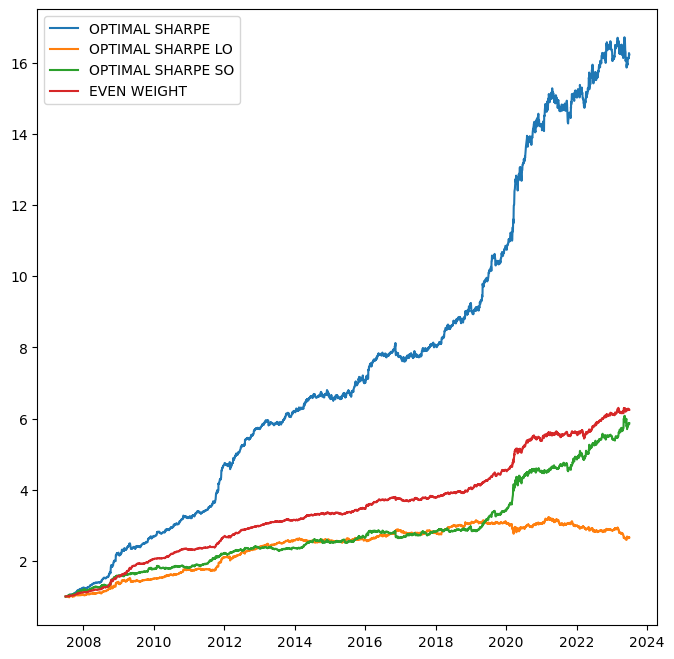

In [148]:
allocationWeight = getAllocationWeights(solution.x)
allocationWeightLO = allocationWeight[np.sign(sim.predicted_c2cdn)==1]
allocationWeightSO = allocationWeight[np.sign(sim.predicted_c2cdn)==-1]
dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
dynamicReturnsLO = (allocationWeightLO*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
dynamicReturnsSO = (allocationWeightSO*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()


simpleReturns = (sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).mean()
fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot((1+dynamicReturns).cumprod(),label='OPTIMAL SHARPE')
plt.plot((1+dynamicReturnsLO).cumprod(),label='OPTIMAL SHARPE LO')
plt.plot((1+dynamicReturnsSO).cumprod(),label='OPTIMAL SHARPE SO')
plt.plot((1+simpleReturns).cumprod(),label='EVEN WEIGHT')
#High rish strategy
hiRiskTrades = sim[(sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=16]
hiRiskReturns = hiRiskTrades.groupby('date')['ew_return'].mean()
#plt.plot((1+hiRiskReturns).cumprod(),label='HI RISK')

plt.legend()
plt.show()

In [190]:
dupes = sim.groupby(['date', 'sym']).filter(lambda group: len(group) > 1)
dupes.shape

(70484, 23)